## This notebook retrieves data from three relevant tables and combines the features we care about into one dataframe. We do this, because merging all of the data is very costly.


**Description of columns**


- **user_id**: Unique identifier for the user (from triplets table).  
- **song_id**: Echo Nest song ID. Multiple tracks can share the same song_id if they are different versions of the same song. However, we removed these duplicates from the track_metadata table.  
- **plays**: Number of times the user played the song (from triplets table).  
- **track_id**: The Echo Nest ID of this particular track on which the analysis was done. Unique identifier for each track within the Million Song Dataset.  
- **title**: Title of the song.  
- **release**: Release (album name) from which the track was taken.  
- **artist_id**: Unique identifier for the artist. Matches the artist_id field in the track_metadata table and artist_term table.  
- **artist_mbid**: MusicBrainz ID (MBID) for the artist.  
- **artist_name**: Name of the artist.  
- **duration**: Duration of the track in seconds.  
- **artist_familiarity**: EchoNest numerical estimation of how familiar a song’s artist currently is to the world.  
- **artist_hotttnesss**: EchoNest numerical estimation of how hottt a song’s artist currently is.  
- **year**: The year the track was released according to MusicBrainz.  
- **track_7digitalid**: Identifier linking the song to the 7digital online music catalog.  
- **shs_perf**: Performance number on the SecondHandSongs website. Default value is -1.  
- **shs_work**: Clique numbers from the SecondHandSongs train and test files. If the work is known by MillionSongs, then the number is positive.  
- **majority_genre**: The most common or dominant genre associated with the artist or track (derived field).  
- **minority_genre**: A secondary or less frequent genre associated with the artist or track (derived field).  

### Retrieve Data

In [1]:
import sqlite3

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import pyarrow  # parquet functionality

In [2]:
# if local
user_song_play_path = "data/train_triplets.txt"
track_metadata_path = "data/track_metadata.db"
genre_labels_path = "data/msd_tagtraum_cd2.cls"

In [3]:
# # if collab
# from google.colab import drive
#
# drive.mount('/content/drive')
# user_song_play_path = "/content/drive/MyDrive/DSE/DSE 220 Final Project/Data/train_triplets.txt"
# track_metadata_path = "/content/drive/MyDrive/DSE/DSE 220 Final Project/Data/track_metadata.db"
# genre_labels_path = "/content/drive/MyDrive/DSE/DSE 220 Final Project/Data/msd_tagtraum_cd2.cls"

In [4]:
# Songs can have multiple track ids, so we retrieve only one
# Once we have only one song we are no longer concerned about "tracks"
track_metadata_conn = sqlite3.connect(track_metadata_path)
track_metadata_sql_query = "SELECT * FROM songs"
song_metadata_df = pd.read_sql_query(
    track_metadata_sql_query,
    track_metadata_conn
).drop_duplicates(subset=['song_id'])
track_metadata_conn.close()

user_song_play_df = pd.read_csv(
    user_song_play_path,
    sep='\t',
    names=['user_id', 'song_id', 'plays'],
)

genre_labels_df = pd.read_csv(
    genre_labels_path,
    sep='\t',
    names=['track_id', 'majority_genre', 'minority_genre'],
    skiprows=7
)

### Combine Data

In [5]:
song_metadata_with_genre_df = pd.merge(
    song_metadata_df,
    genre_labels_df,
    on='track_id',
    how='left'  # so we can keep all rows
)

In [6]:
songs_cols_to_keep = ['song_id', 'track_id', 'title', 'release', 'duration',
                      'artist_id', 'artist_name',
                      'artist_familiarity', 'artist_hotttnesss', 'year', 'majority_genre', 'minority_genre']
song_metadata_with_genre_df = song_metadata_with_genre_df[songs_cols_to_keep]

In [7]:
song_metadata_with_genre_df.head()

song_id            track_id              title  \
0  SOQMMHC12AB0180CB8  TRMMMYQ128F932D901       Silent Night   
1  SOVFVAK12A8C1350D9  TRMMMKD128F425225D        Tanssi vaan   
2  SOGTUKN12AB017F4F1  TRMMMRX128F93187D9  No One Could Ever   
3  SOBNYVR12A8C13558C  TRMMMCH128F425532C      Si Vos Querés   
4  SOHSBXH12A8C13B0DF  TRMMMWA128F426B589   Tangle Of Aspens   

                                release   duration           artist_id  \
0                 Monster Ballads X-Mas  252.05506  ARYZTJS1187B98C555   
1                           Karkuteillä  156.55138  ARMVN3U1187FB3A1EB   
2                                Butter  138.97098  ARGEKB01187FB50750   
3                               De Culo  145.05751  ARNWYLR1187B9B2F9C   
4  Rene Ablaze Presents Winter Sessions  514.29832  AREQDTE1269FB37231   

        artist_name  artist_familiarity  artist_hotttnesss  year  \
0  Faster Pussy cat            0.649822           0.394032  2003   
1  Karkkiautomaatti            0.439604           0.356992  1995   
2    Hudson Mohawke            0.643681           0.437504  2006   
3       Yerba Brava            0.448501           0.372349  2003   
4        Der Mystic            0.000000           0.000000     0   

  majority_genre minority_genre  
0            NaN            NaN  
1            NaN            NaN  
2     Electronic            Rap  
3            NaN            NaN  
4            NaN            NaN

In [8]:
song_metadata_with_genre_df_clean = song_metadata_with_genre_df.dropna(subset=['majority_genre'])
song_metadata_with_genre_df_clean = song_metadata_with_genre_df_clean[song_metadata_with_genre_df_clean['year'] != 0]

In [9]:
song_metadata_with_genre_df_clean['year'].value_counts()

year
2007    17538
2006    16646
2005    15620
2008    13968
2004    13031
        ...  
1943        6
1933        4
1925        4
1922        3
1924        2
Name: count, Length: 88, dtype: int64

In [10]:
song_metadata_with_genre_df_clean.describe(include='all')

song_id            track_id   title        release  \
count               222919              222919  222919         222919   
unique              222919              222919  173050          55865   
top     SOGTUKN12AB017F4F1  TRMMMRX128F93187D9   Intro  Greatest Hits   
freq                     1                   1     285            725   
mean                   NaN                 NaN     NaN            NaN   
std                    NaN                 NaN     NaN            NaN   
min                    NaN                 NaN     NaN            NaN   
25%                    NaN                 NaN     NaN            NaN   
50%                    NaN                 NaN     NaN            NaN   
75%                    NaN                 NaN     NaN            NaN   
max                    NaN                 NaN     NaN            NaN   

             duration           artist_id        artist_name  \
count   222919.000000              222919             222919   
unique            NaN               20789              22851   
top               NaN  AR91C8S1187B990901  Bruce Springsteen   
freq              NaN                 140                127   
mean       251.862589                 NaN                NaN   
std        110.335887                 NaN                NaN   
min          0.600360                 NaN                NaN   
25%        189.988120                 NaN                NaN   
50%        234.579140                 NaN                NaN   
75%        289.932610                 NaN                NaN   
max       2999.509750                 NaN                NaN   

        artist_familiarity  artist_hotttnesss           year majority_genre  \
count        222919.000000      222919.000000  222919.000000         222919   
unique                 NaN                NaN            NaN             15   
top                    NaN                NaN            NaN           Rock   
freq                   NaN                NaN            NaN          93507   
mean              0.636693           0.444543    1998.176140            NaN   
std               0.113975           0.097839      10.939399            NaN   
min               0.000000           0.000000    1922.000000            NaN   
25%               0.565935           0.386480    1994.000000            NaN   
50%               0.632131           0.434256    2002.000000            NaN   
75%               0.710901           0.498842    2006.000000            NaN   
max               1.000000           1.082503    2010.000000            NaN   

       minority_genre  
count           70319  
unique             15  
top              Rock  
freq            15877  
mean              NaN  
std               NaN  
min               NaN  
25%               NaN  
50%               NaN  
75%               NaN  
max               NaN

In [11]:
songs_df_full = pd.merge(user_song_play_df, song_metadata_with_genre_df, on='song_id')
# Calculate the amount of time a user spent listening to a particular song
songs_df_full['tot_track_time'] = songs_df_full['duration'] * songs_df_full['plays']
# Drop songs without a majority genre
songs_df = songs_df_full.dropna(subset=['majority_genre'])
songs_df = songs_df[songs_df['year'] != 0]

In [12]:
print(songs_df_full.columns)
print(songs_df.columns)

Index(['user_id', 'song_id', 'plays', 'track_id', 'title', 'release',
       'duration', 'artist_id', 'artist_name', 'artist_familiarity',
       'artist_hotttnesss', 'year', 'majority_genre', 'minority_genre',
       'tot_track_time'],
      dtype='object')
Index(['user_id', 'song_id', 'plays', 'track_id', 'title', 'release',
       'duration', 'artist_id', 'artist_name', 'artist_familiarity',
       'artist_hotttnesss', 'year', 'majority_genre', 'minority_genre',
       'tot_track_time'],
      dtype='object')


In [13]:
user_total_plays = songs_df.groupby('user_id', as_index=False)['plays'].sum().rename(
    columns={'plays': 'total_play_count'})

user_unique_songs = songs_df.groupby('user_id', as_index=False)['song_id'].count().rename(
    columns={'song_id': 'unqiue_song_count'})
user_unique_artists = songs_df.groupby('user_id', as_index=False)['artist_id'].count().rename(
    columns={'artist_id': 'unqiue_artist_count'})
user_total_time = songs_df.groupby('user_id', as_index=False)['tot_track_time'].sum().rename(
    columns={'tot_track_time': 'total_play_time'})

user_fav_artist = songs_df.groupby('user_id', as_index=False)['artist_id'].value_counts()
user_fav_artist = user_fav_artist.loc[user_fav_artist.groupby('user_id')['count'].idxmax()].rename(
    columns={'artist_id': 'fav_artist', "count": "fav_artist_plays"})

user_fav_maj_genre = songs_df.groupby('user_id', as_index=False)['majority_genre'].value_counts()
user_fav_maj_genre = user_fav_maj_genre.loc[user_fav_maj_genre.groupby('user_id')['count'].idxmax()].rename(
    columns={'majority_genre': 'fav_maj_genre', "count": "fav_maj_count"})
user_fav_min_genre = songs_df.groupby('user_id', as_index=False)['minority_genre'].value_counts()
user_fav_min_genre = user_fav_min_genre.loc[user_fav_min_genre.groupby('user_id')['count'].idxmax()].rename(
    columns={'minority_genre': 'fav_min_genre', "count": "fav_min_count"})

user_fav_year = songs_df.groupby('user_id', as_index=False)['year'].value_counts()
user_fav_year = user_fav_year[user_fav_year['year'] != 0]
user_fav_year = user_fav_year.loc[user_fav_year.groupby('user_id')['count'].idxmax()].rename(
    columns={'year': 'fav_year', "count": "year_count"})

user_fav_song = songs_df.loc[songs_df.groupby('user_id')['plays'].idxmax()]
user_fav_song = user_fav_song[['user_id', 'song_id', 'plays', 'duration', 'tot_track_time']].rename(
    columns={'song_id': 'fav_song', "plays": "fav_song_plays", 'duration': 'fav_song_duration',
             'tot_track_time': 'tot_fav_song_play_time'})

#### Create final df pulling relevant features

In [14]:
users_df = pd.merge(user_total_plays, user_total_time, on="user_id")
users_df = pd.merge(users_df, user_unique_artists, on="user_id")
users_df = pd.merge(users_df, user_unique_songs, on="user_id")
users_df = pd.merge(users_df, user_fav_maj_genre, on="user_id")
users_df = pd.merge(users_df, user_fav_min_genre, on="user_id")
users_df = pd.merge(users_df, user_fav_year, on="user_id")
users_df = pd.merge(users_df, user_fav_artist, on="user_id")
users_df = pd.merge(users_df, user_fav_song, on="user_id")

In [15]:
users_df.describe()

total_play_count  total_play_time  unqiue_artist_count  \
count     933431.000000     9.334310e+05        933431.000000   
mean          75.072520     1.860510e+04            27.352648   
std          106.195572     2.630841e+04            35.009184   
min            1.000000     5.289751e+01             1.000000   
25%           17.000000     4.263698e+03             9.000000   
50%           39.000000     9.661946e+03            15.000000   
75%           90.000000     2.224083e+04            32.000000   
max        11697.000000     2.408770e+06          2365.000000   

       unqiue_song_count  fav_maj_count  fav_min_count       fav_year  \
count      933431.000000  933431.000000  933431.000000  933431.000000   
mean           27.352648      15.393956       3.465819    2001.049530   
std            35.009184      21.173470       4.441338      10.043838   
min             1.000000       1.000000       1.000000    1924.000000   
25%             9.000000       4.000000       1.000000    1999.000000   
50%            15.000000       8.000000       2.000000    2005.000000   
75%            32.000000      18.000000       4.000000    2008.000000   
max          2365.000000    1411.000000     216.000000    2010.000000   

          year_count  fav_artist_plays  fav_song_plays  fav_song_duration  \
count  933431.000000     933431.000000   933431.000000      933431.000000   
mean        5.766003          5.351766       12.863076         250.970620   
std         5.842962          5.855139       24.700324          88.089775   
min         1.000000          1.000000        1.000000           1.122810   
25%         2.000000          2.000000        3.000000         202.579140   
50%         4.000000          3.000000        7.000000         237.792200   
75%         7.000000          7.000000       15.000000         280.972610   
max       267.000000         80.000000     9667.000000        2328.110570   

       tot_fav_song_play_time  
count            9.334310e+05  
mean             3.232460e+03  
std              6.284949e+03  
min              1.122810e+00  
25%              7.644455e+02  
50%              1.658510e+03  
75%              3.603012e+03  
max              1.948484e+06

### Compare data when dropping year = 0 vs not dropping it (year=0 is the same as year = NaN)


In [16]:
smg_df = song_metadata_with_genre_df_clean[song_metadata_with_genre_df_clean['year'] != 0]
smg_df.describe(include='all')

song_id            track_id   title        release  \
count               222919              222919  222919         222919   
unique              222919              222919  173050          55865   
top     SOGTUKN12AB017F4F1  TRMMMRX128F93187D9   Intro  Greatest Hits   
freq                     1                   1     285            725   
mean                   NaN                 NaN     NaN            NaN   
std                    NaN                 NaN     NaN            NaN   
min                    NaN                 NaN     NaN            NaN   
25%                    NaN                 NaN     NaN            NaN   
50%                    NaN                 NaN     NaN            NaN   
75%                    NaN                 NaN     NaN            NaN   
max                    NaN                 NaN     NaN            NaN   

             duration           artist_id        artist_name  \
count   222919.000000              222919             222919   
unique            NaN               20789              22851   
top               NaN  AR91C8S1187B990901  Bruce Springsteen   
freq              NaN                 140                127   
mean       251.862589                 NaN                NaN   
std        110.335887                 NaN                NaN   
min          0.600360                 NaN                NaN   
25%        189.988120                 NaN                NaN   
50%        234.579140                 NaN                NaN   
75%        289.932610                 NaN                NaN   
max       2999.509750                 NaN                NaN   

        artist_familiarity  artist_hotttnesss           year majority_genre  \
count        222919.000000      222919.000000  222919.000000         222919   
unique                 NaN                NaN            NaN             15   
top                    NaN                NaN            NaN           Rock   
freq                   NaN                NaN            NaN          93507   
mean              0.636693           0.444543    1998.176140            NaN   
std               0.113975           0.097839      10.939399            NaN   
min               0.000000           0.000000    1922.000000            NaN   
25%               0.565935           0.386480    1994.000000            NaN   
50%               0.632131           0.434256    2002.000000            NaN   
75%               0.710901           0.498842    2006.000000            NaN   
max               1.000000           1.082503    2010.000000            NaN   

       minority_genre  
count           70319  
unique             15  
top              Rock  
freq            15877  
mean              NaN  
std               NaN  
min               NaN  
25%               NaN  
50%               NaN  
75%               NaN  
max               NaN

In [17]:
songs_smg_df = pd.merge(user_song_play_df, smg_df, on='song_id')

songs_smg_df['tot_track_time'] = songs_smg_df['duration'] * songs_smg_df['plays']

songs_smg_df.head()

user_id             song_id  plays  \
0  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOAPDEY12A81C210A9      1   
1  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBBMDR12A8C13253B      2   
2  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBFNSP12AF72A0E22      1   
3  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBSUJE12A6D4F8CF5      2   
4  b80344d063b5ccb3212f76538f3d9e43d87dca9e  SOBXHDL12A81C204C0      1   

             track_id                     title                release  \
0  TRIRLYL128F42539D1      Nothing from Nothing             To Die For   
1  TRMHBXZ128F4238406           Entre Dos Aguas    Flamenco Para Niños   
2  TRYQMNI128F147C1C7     Under Cold Blue Stars  Under Cold Blue Stars   
3  TRPLAXZ128F4292406  12 segundos de oscuridad        10 + Downloaded   
4  TRHNCIR128F42334A5                  Stronger             Graduation   

    duration           artist_id    artist_name  artist_familiarity  \
0  153.59955  ARHYUI71187FB48366  Billy Preston            0.580555   
1  358.24281  ARC1SF21187FB51D0F  Paco De Lucia            0.633119   
2  266.34404  ARMS97V1187B99DD98     Josh Rouse            0.675339   
3  246.83057  AR1BQ6Y1187B98D586  Jorge Drexler            0.641037   
4  311.84934  ARRH63Y1187FB47783     Kanye West            0.877214   

   artist_hotttnesss  year majority_genre minority_genre  tot_track_time  
0           0.482492  1974            RnB            NaN       153.59955  
1           0.417718  1976     Electronic          Metal       716.48562  
2           0.509058  2002           Rock            NaN       266.34404  
3           0.412069  2006          Latin            Pop       493.66114  
4           1.082503  2007            Rap            NaN       311.84934

In [18]:
users_total_plays_smg = songs_smg_df.groupby('user_id', as_index=False)['plays'].sum().rename(
    columns={'plays': 'total_play_count'})

users_unique_songs_smg = songs_smg_df.groupby('user_id', as_index=False)['song_id'].count().rename(
    columns={'song_id': 'unqiue_song_count'})
users_unique_artists_smg = songs_smg_df.groupby('user_id', as_index=False)['artist_id'].count().rename(
    columns={'artist_id': 'unqiue_artist_count'})

users_total_time_smg = songs_smg_df.groupby('user_id', as_index=False)['tot_track_time'].sum().rename(
    columns={'tot_track_time': 'total_play_time'})
user_fav_artist_smg = songs_smg_df.groupby('user_id', as_index=False)['artist_id'].value_counts()
user_fav_artist_smg = user_fav_artist_smg.loc[user_fav_artist_smg.groupby('user_id')['count'].idxmax()].rename(
    columns={'artist_id': 'fav_artist', "count": "fav_artist_plays"})

user_fav_maj_genre_smg = songs_smg_df.groupby('user_id', as_index=False)['majority_genre'].value_counts()
user_fav_maj_genre_smg = user_fav_maj_genre_smg.loc[user_fav_maj_genre_smg.groupby('user_id')['count'].idxmax()].rename(
    columns={'majority_genre': 'fav_maj_genre', "count": "fav_maj_count"})
user_fav_min_genre_smg = songs_smg_df.groupby('user_id', as_index=False)['minority_genre'].value_counts()
user_fav_min_genre_smg = user_fav_min_genre_smg.loc[user_fav_min_genre_smg.groupby('user_id')['count'].idxmax()].rename(
    columns={'minority_genre': 'fav_min_genre', "count": "fav_min_count"})

user_fav_year_smg = songs_smg_df.groupby('user_id', as_index=False)['year'].value_counts()
user_fav_year_smg = user_fav_year_smg[user_fav_year_smg['year'] != 0]
user_fav_year_smg = user_fav_year_smg.loc[user_fav_year_smg.groupby('user_id')['count'].idxmax()].rename(
    columns={'year': 'fav_year', "count": "year_count"})

user_fav_song_smg = songs_smg_df.loc[songs_smg_df.groupby('user_id')['plays'].idxmax()]
user_fav_song_smg = user_fav_song_smg[['user_id', 'song_id', 'plays', 'duration', 'tot_track_time']].rename(
    columns={'song_id': 'fav_song', "plays": "fav_song_plays", 'duration': 'fav_song_duration',
             'tot_track_time': 'tot_fav_song_play_time'})

In [19]:
users_smg_df = pd.merge(users_total_plays_smg, users_total_time_smg, on="user_id")
users_smg_df = pd.merge(users_smg_df, users_unique_artists_smg, on="user_id")
users_smg_df = pd.merge(users_smg_df, users_unique_songs_smg, on="user_id")
users_smg_df = pd.merge(users_smg_df, user_fav_maj_genre_smg, on="user_id")
users_smg_df = pd.merge(users_smg_df, user_fav_min_genre_smg, on="user_id")
users_smg_df = pd.merge(users_smg_df, user_fav_year_smg, on="user_id")
users_smg_df = pd.merge(users_smg_df, user_fav_artist_smg, on="user_id")
users_smg_df = pd.merge(users_smg_df, user_fav_song_smg, on="user_id")

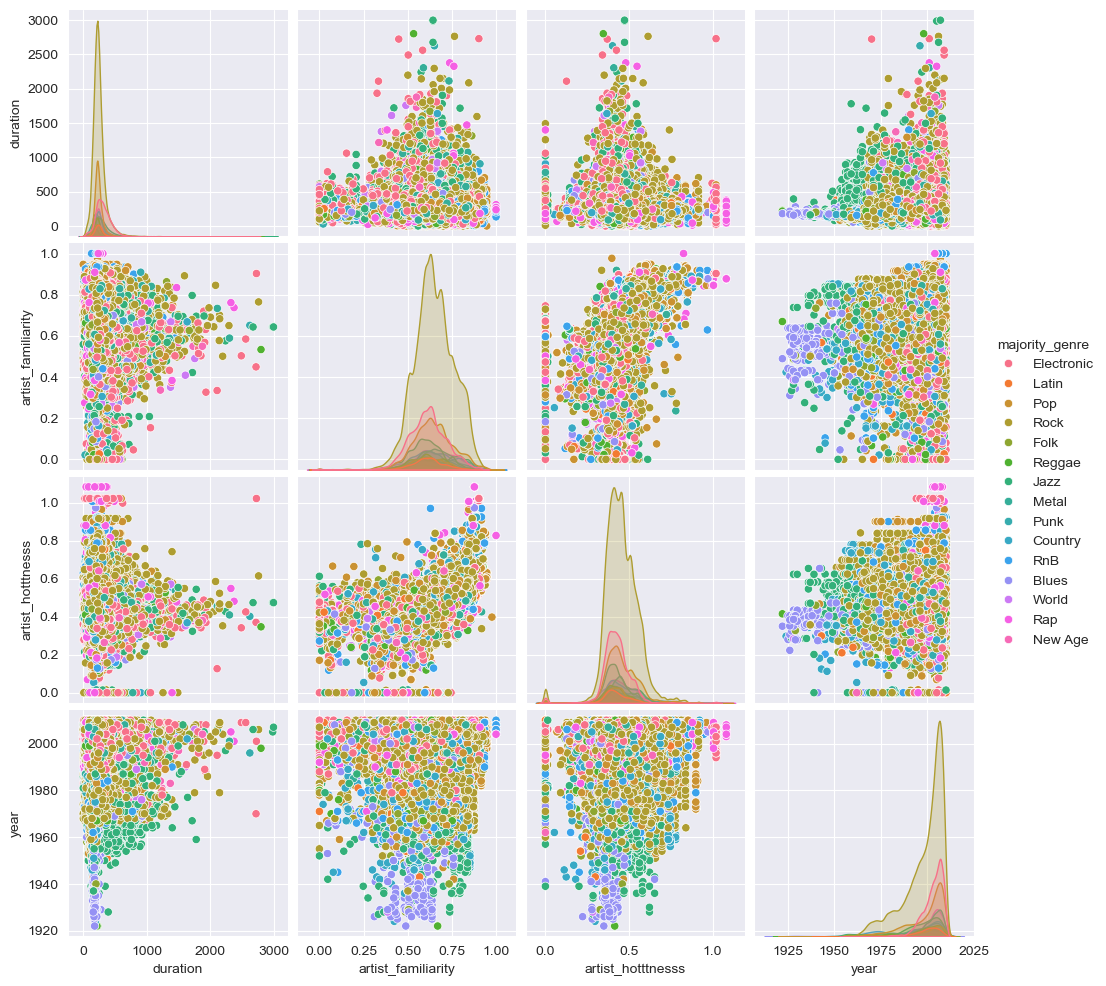

In [20]:
sns.pairplot(smg_df, hue='majority_genre')
plt.show()

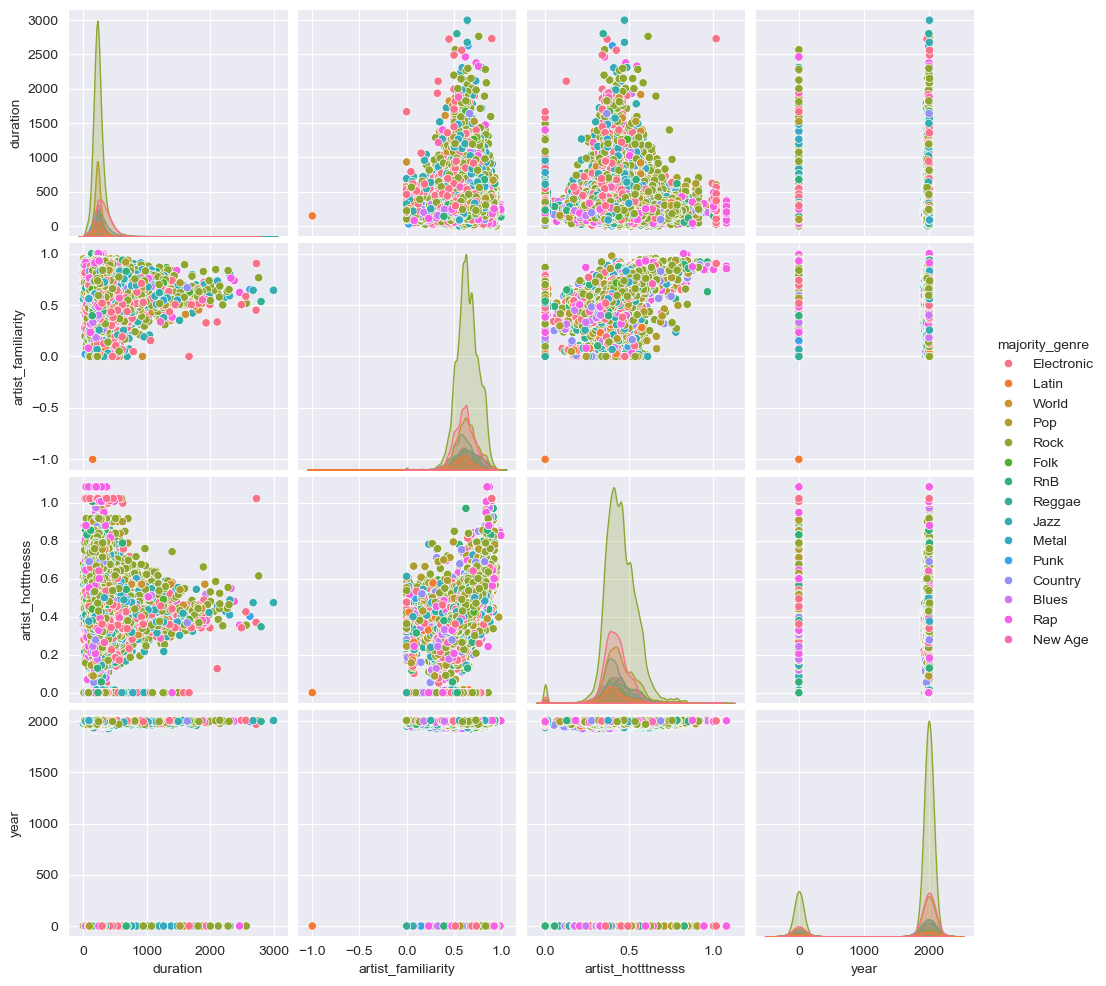

In [21]:
# num_df = song_metadata_with_genre_df_clean.select_dtypes(include='number')
sns.pairplot(song_metadata_with_genre_df, hue='majority_genre')
plt.show()

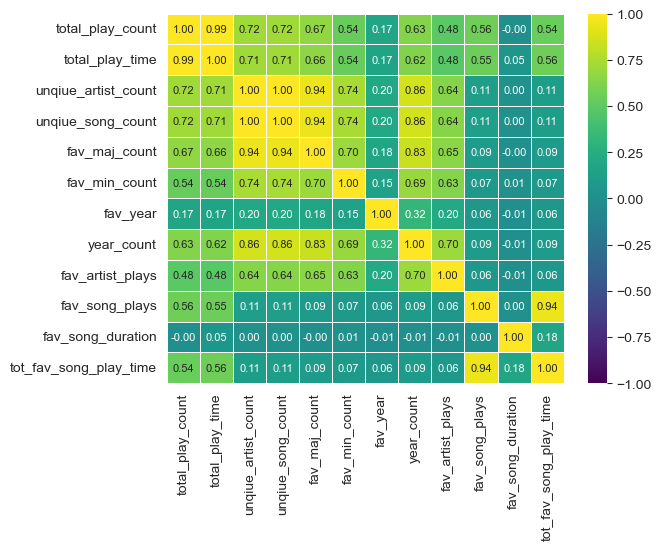

In [22]:
sns.heatmap(users_smg_df.select_dtypes(include='number').corr(), annot=True, cmap='viridis', fmt='.2f', linewidths=.5,
            annot_kws={"size": 8}, vmin=-1, vmax=1)
plt.show()

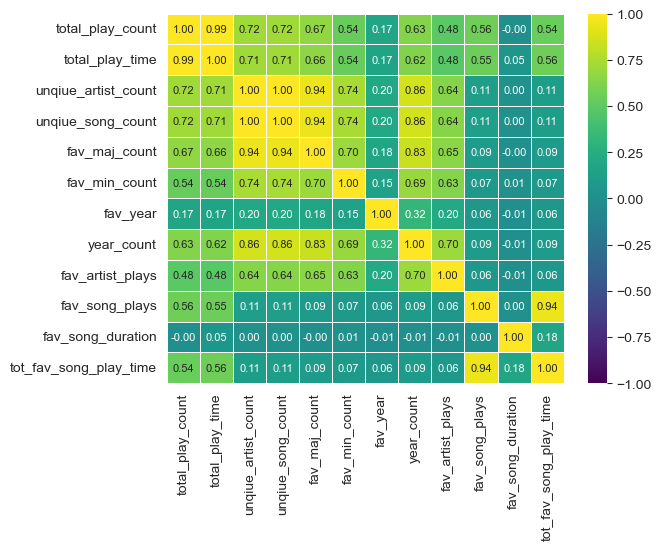

In [23]:
sns.heatmap(users_df.select_dtypes(include='number').corr(), annot=True, cmap='viridis', fmt='.2f', linewidths=.5,
            annot_kws={"size": 8}, vmin=-1, vmax=1)
plt.show()

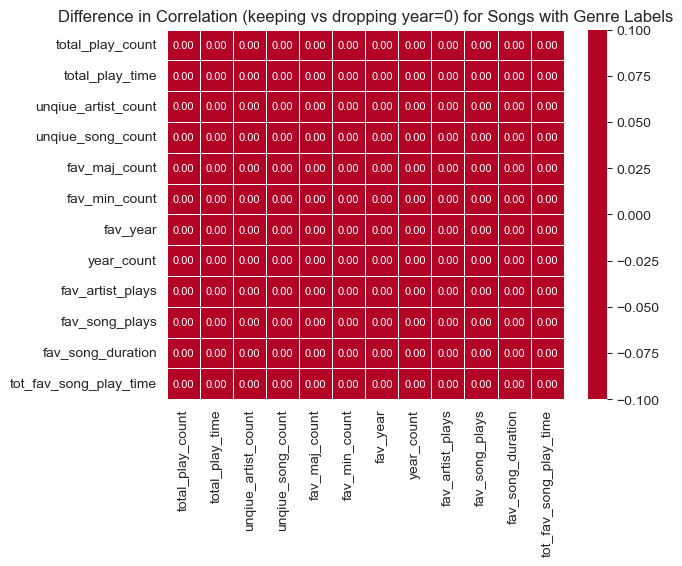

In [24]:
sns.heatmap(users_df.select_dtypes(include='number').corr() - users_smg_df.select_dtypes(include='number').corr(),
            annot=True, cmap='coolwarm_r', fmt='.2f', linewidths=.5, annot_kws={"size": 8},
            center=0)  #, vmin=-1, vmax=1)
plt.title('Difference in Correlation (keeping vs dropping year=0) for Songs with Genre Labels')
plt.show()

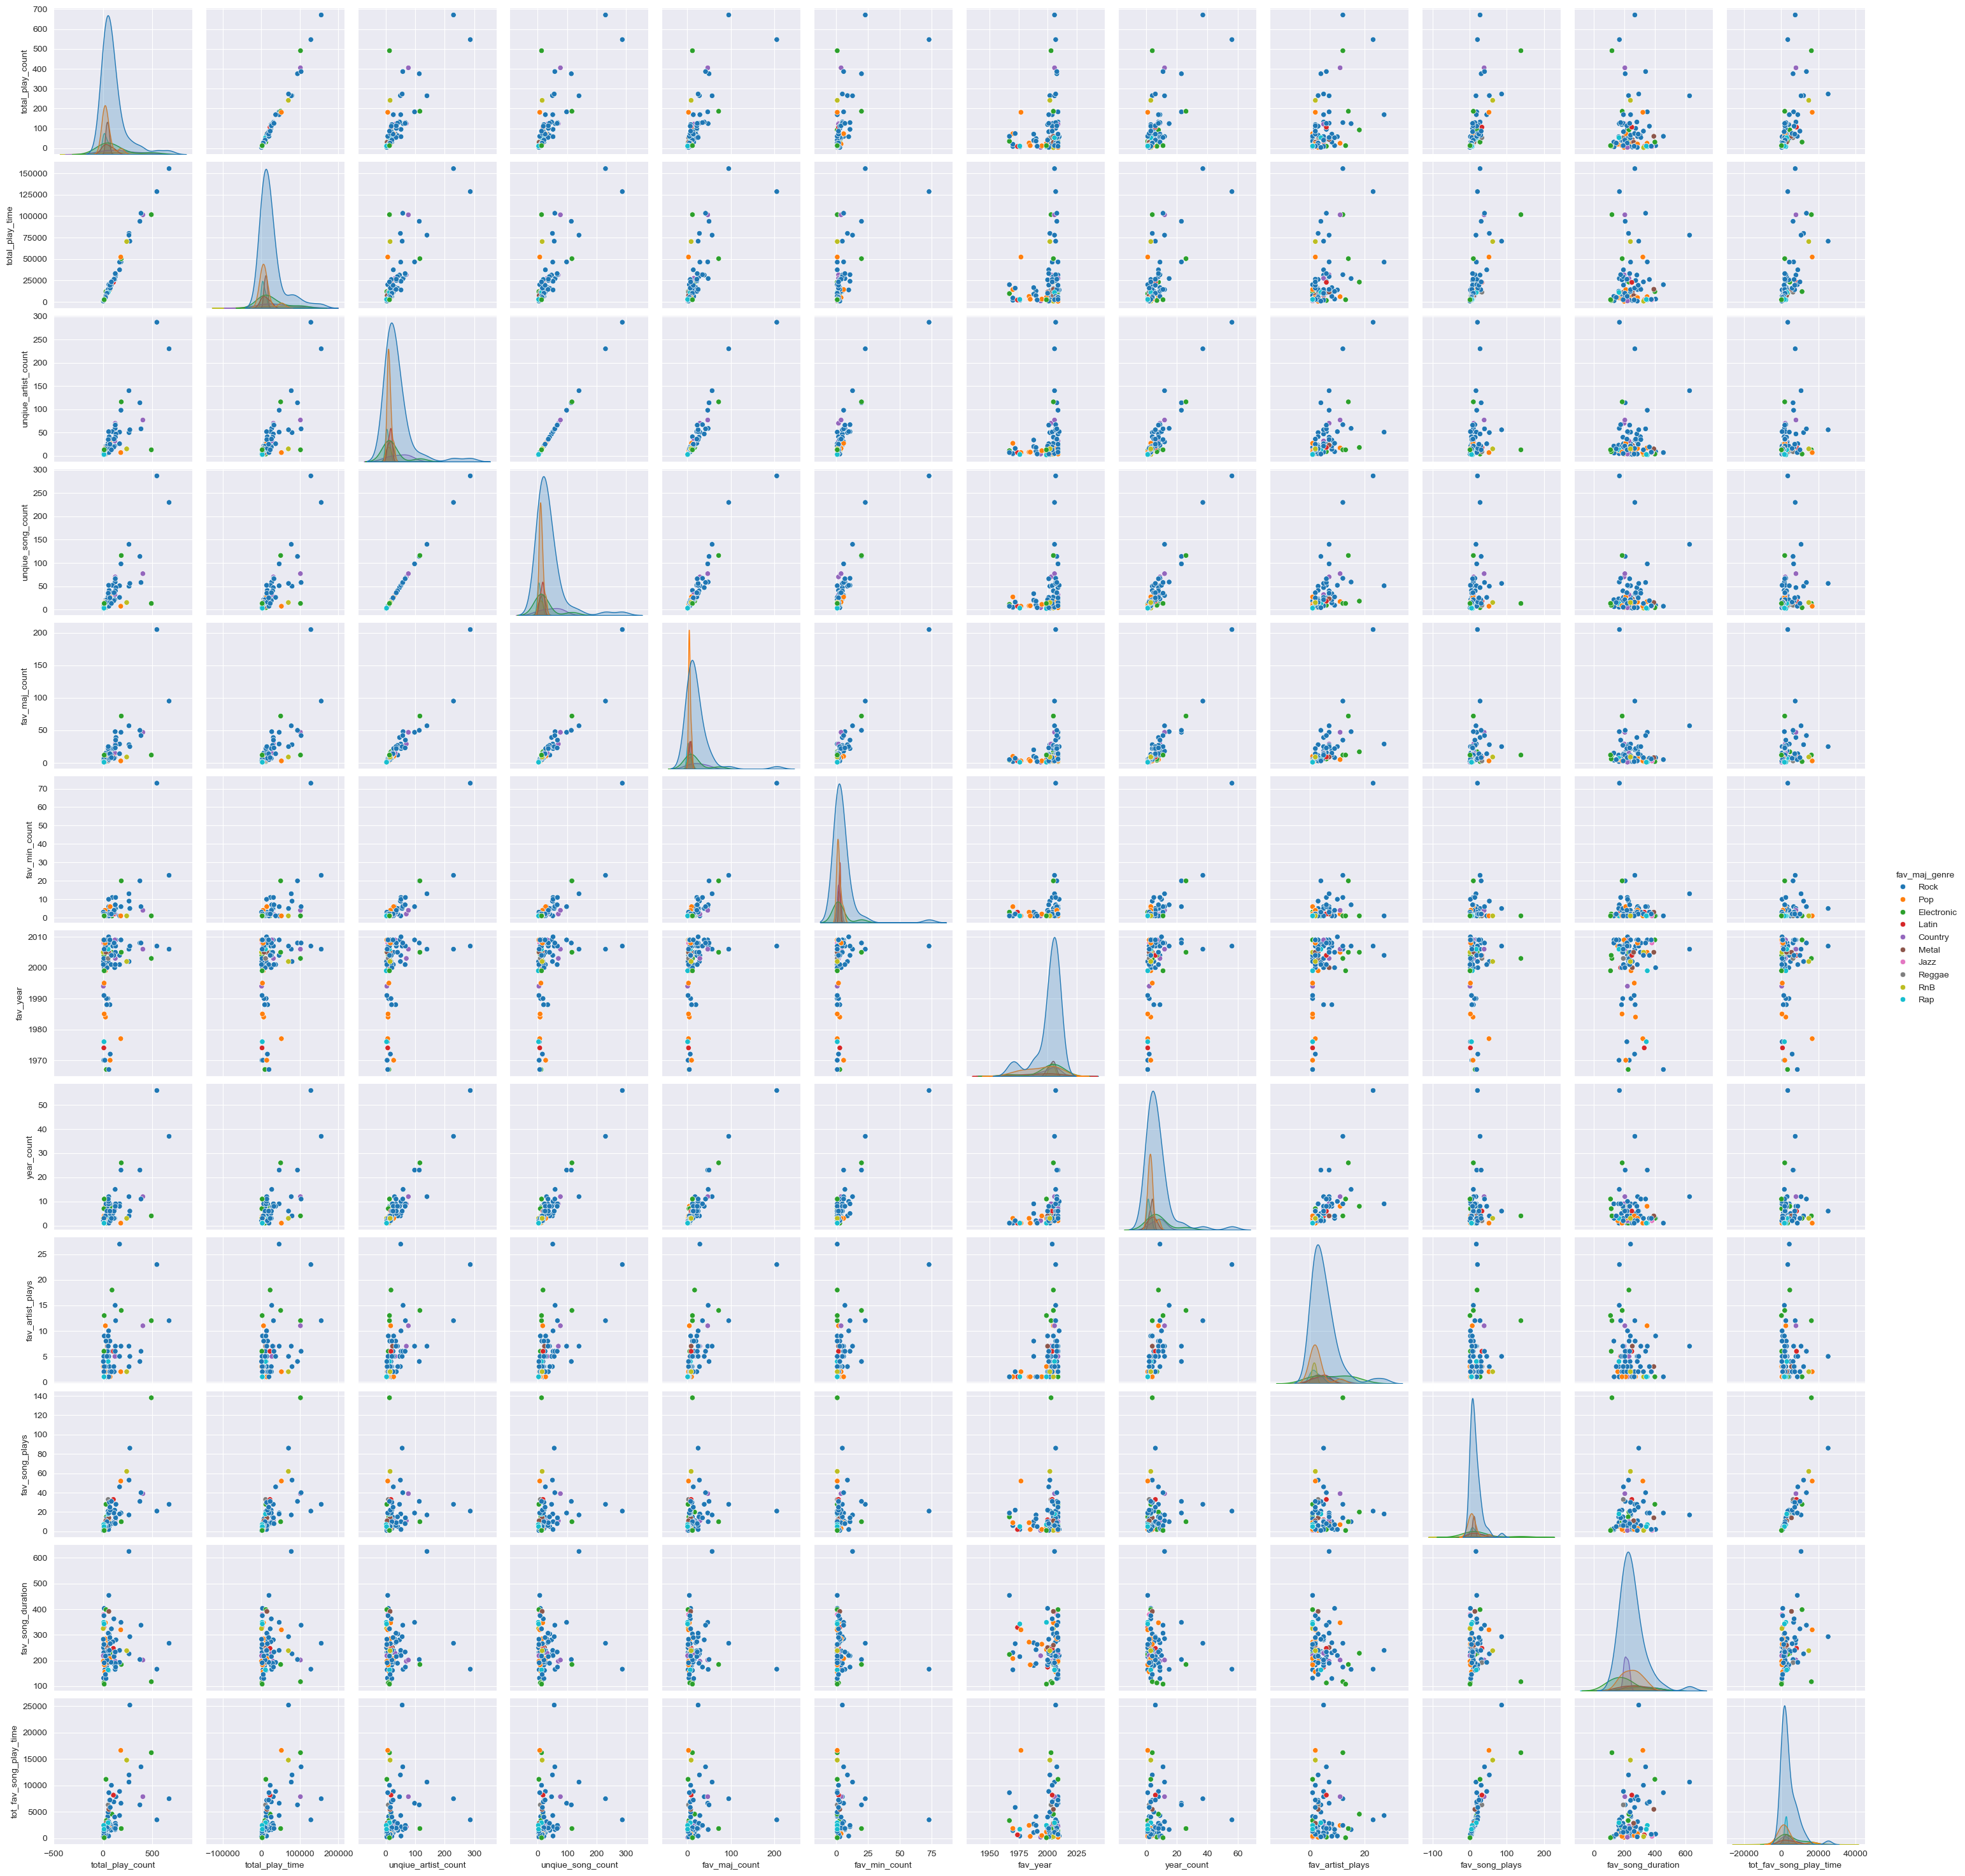

In [25]:
sns.pairplot(users_smg_df.sample(frac=0.0001), hue='fav_maj_genre')
plt.show()

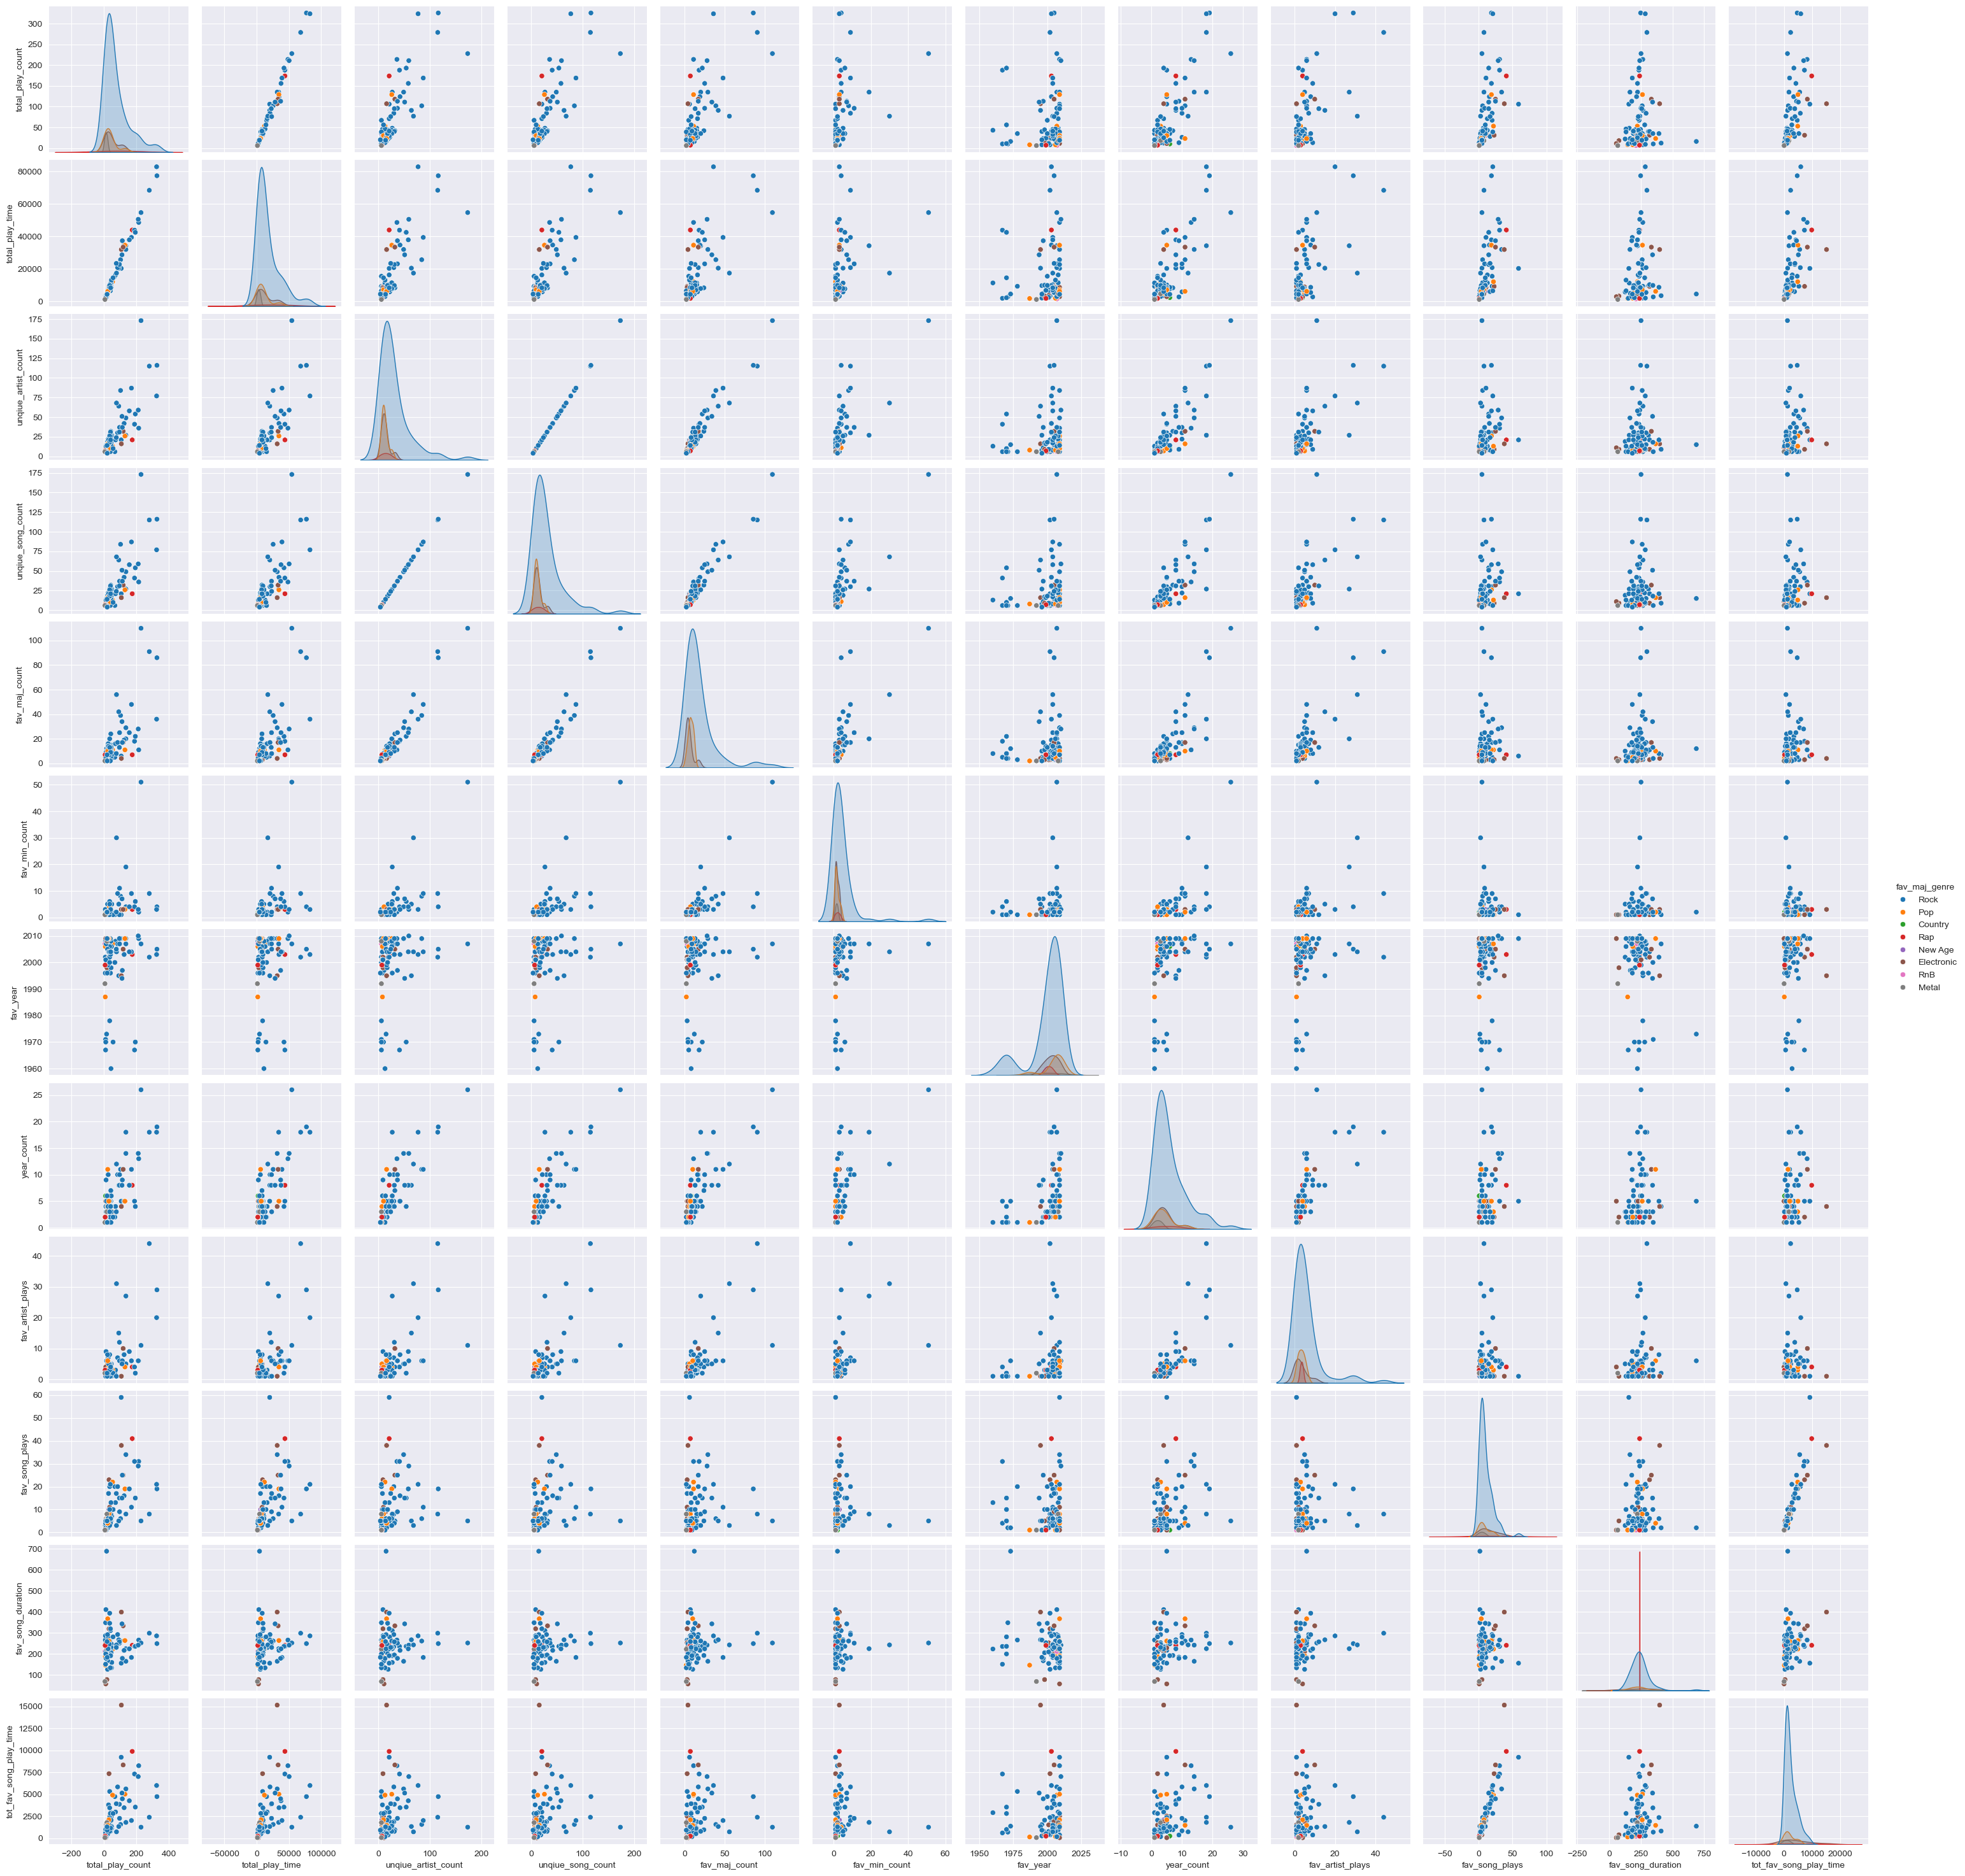

In [26]:
sns.pairplot(users_df.sample(frac=0.0001), hue='fav_maj_genre')
plt.show()

### Save processed data frames for other notebooks to process further and use

In [27]:
songs_df = songs_df[songs_df['year'] != 0]

In [28]:
songs_df.describe(include='all')

user_id             song_id  \
count                                   26102714            26102714   
unique                                   1017516              144105   
top     ec6dfcf19485cb011e0b22637075037aae34cf26  SOAUWYT12A81C206F1   
freq                                        2365               90476   
mean                                         NaN                 NaN   
std                                          NaN                 NaN   
min                                          NaN                 NaN   
25%                                          NaN                 NaN   
50%                                          NaN                 NaN   
75%                                          NaN                 NaN   
max                                          NaN                 NaN   

               plays            track_id     title        release  \
count   2.610271e+07            26102714  26102714       26102714   
unique           NaN              144105    118258          38664   
top              NaN  TRGXQES128F42BA5EB      Undo  Greatest Hits   
freq             NaN               90476     90476         179038   
mean    2.751063e+00                 NaN       NaN            NaN   
std     6.314971e+00                 NaN       NaN            NaN   
min     1.000000e+00                 NaN       NaN            NaN   
25%     1.000000e+00                 NaN       NaN            NaN   
50%     1.000000e+00                 NaN       NaN            NaN   
75%     2.000000e+00                 NaN       NaN            NaN   
max     9.667000e+03                 NaN       NaN            NaN   

            duration           artist_id artist_name  artist_familiarity  \
count   2.610271e+07            26102714    26102714        2.610271e+07   
unique           NaN               16577       17869                 NaN   
top              NaN  ARJ7KF01187B98D717    Coldplay                 NaN   
freq             NaN              314683      314683                 NaN   
mean    2.473164e+02                 NaN         NaN        7.496611e-01   
std     8.813194e+01                 NaN         NaN        1.074408e-01   
min     7.832200e-01                 NaN         NaN        0.000000e+00   
25%     2.001236e+02                 NaN         NaN        6.806601e-01   
50%     2.348926e+02                 NaN         NaN        7.648824e-01   
75%     2.773938e+02                 NaN         NaN        8.347145e-01   
max     2.999510e+03                 NaN         NaN        1.000000e+00   

        artist_hotttnesss          year majority_genre minority_genre  \
count        2.610271e+07  2.610271e+07       26102714        7034833   
unique                NaN           NaN             15             15   
top                   NaN           NaN           Rock           Rock   
freq                  NaN           NaN       12947754        1660899   
mean         5.602048e-01  2.000681e+03            NaN            NaN   
std          1.322835e-01  9.339874e+00            NaN            NaN   
min          0.000000e+00  1.922000e+03            NaN            NaN   
25%          4.744282e-01  1.997000e+03            NaN            NaN   
50%          5.411549e-01  2.004000e+03            NaN            NaN   
75%          6.051912e-01  2.007000e+03            NaN            NaN   
max          1.082503e+00  2.010000e+03            NaN            NaN   

        tot_track_time  
count     2.610271e+07  
unique             NaN  
top                NaN  
freq               NaN  
mean      6.817397e+02  
std       1.630573e+03  
min       7.832200e-01  
25%       2.224322e+02  
50%       2.966461e+02  
75%       6.094885e+02  
max       1.948484e+06

In [29]:
# if local
users_cleaned_df_path = "data/users_cleaned_df.parquet"
songs_df_cleaned_path = "data/songs_df_cleaned.parquet"

In [30]:
# # if collab
# users_cleaned_df_path = "/content/drive/MyDrive/DSE/DSE 220 Final Project/Data/users_cleaned_df.parquet"
# songs_df_cleaned_path = "/content/drive/MyDrive/DSE/DSE 220 Final Project/Data/songs_df_cleaned.parquet"

In [33]:
users_df.to_parquet(users_cleaned_df_path, index=False, engine='pyarrow')
print(f"Processed DataFrame saved to: {users_cleaned_df_path}")

Processed DataFrame saved to: data/users_cleaned_df.parquet


In [34]:
songs_df.to_parquet(songs_df_cleaned_path, index=False, engine='pyarrow')
print(f"Processed DataFrame saved to: {songs_df_cleaned_path}")

Processed DataFrame saved to: data/songs_df_cleaned.parquet
